# 🧠 Mercor AI Text Detection — Stacking Ensemble Notebook

This notebook builds a full stacking and blending pipeline for the Mercor AI Text Detection Kaggle competition.  
It includes:
- TF-IDF and feature engineering
- Multiple base models (Logistic Regression, Random Forest, XGBoost, LightGBM)
- Meta-model stacking (LGBM / Logistic Regression)
- Final submission generation (`stacked_submission.csv`, `stacked_submission_2.csv`, `super_blend_submission.csv`)

## 👨‍💻 Authors
**Gaurav Singh** & **Ayush Gahtori**

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from scipy.sparse import hstack
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier

In [66]:
train_path = "../Mecor_Data/train.csv"
test_path = "../Mecor_Data/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("✅ Data loaded successfully!")

for df in [train_df, test_df]:
    df["text_length"] = df["answer"].apply(len)
    df["num_words"] = df["answer"].apply(lambda x: len(x.split()))
    df["num_digits"] = df["answer"].apply(lambda x: sum(c.isdigit() for c in x))
    df["num_upper"] = df["answer"].apply(lambda x: sum(c.isupper() for c in x))

print("✅ Added new text-based features:")

✅ Data loaded successfully!
✅ Added new text-based features:


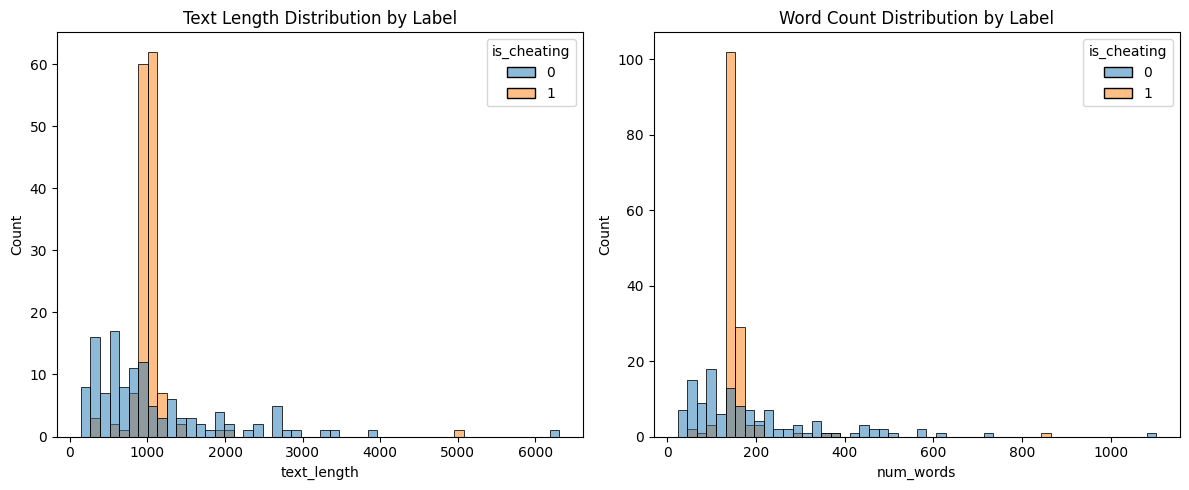

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=train_df, x='text_length', bins=50, hue='is_cheating', ax=axes[0])
axes[0].set_title("Text Length Distribution by Label")

sns.histplot(data=train_df, x='num_words', bins=50, hue='is_cheating', ax=axes[1])
axes[1].set_title("Word Count Distribution by Label")

plt.tight_layout()
plt.show()

In [68]:
vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1, 2), stop_words='english')
X_tfidf = vectorizer.fit_transform(train_df['answer'])
X_test_tfidf = vectorizer.transform(test_df['answer'])

num_features = ['text_length', 'num_words', 'num_digits', 'num_upper']
X_train_combined = hstack([X_tfidf, train_df[num_features].values])
X_test_combined = hstack([X_test_tfidf, test_df[num_features].values])

y = train_df['is_cheating']

print("✅ Combined TF-IDF and numeric features!")

✅ Combined TF-IDF and numeric features!


In [69]:
base_models = {
    "lr": LogisticRegression(max_iter=1000, solver='liblinear'),
    "rf": RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42),
    "xgb": XGBClassifier(eval_metric='logloss', n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42),
    "lgb": LGBMClassifier(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
}

oof_preds = np.zeros((len(train_df), len(base_models)))
test_preds = np.zeros((len(test_df), len(base_models)))

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X_train_combined = X_train_combined.tocsr()

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_combined, y)):
    X_tr, X_val = X_train_combined[train_idx], X_train_combined[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    for i, (name, model) in enumerate(base_models.items()):
        model.fit(X_tr, y_tr)
        val_preds = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx, i] = val_preds
        test_preds[:, i] += model.predict_proba(X_test_combined)[:, 1] / kf.n_splits
        score = roc_auc_score(y_val, val_preds)
        print(f"{name} fold ROC-AUC: {score:.4f}")

print("\n✅ Base model training done! Meta features created:", oof_preds.shape)

lr fold ROC-AUC: 0.9403
rf fold ROC-AUC: 0.9667
xgb fold ROC-AUC: 0.9486
[LightGBM] [Info] Number of positive: 117, number of negative: 98
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 215, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544186 -> initscore=0.177206
[LightGBM] [Info] Start training from score 0.177206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

c:\Users\asus\Desktop\Mecor_Text_Dection_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\asus\Desktop\Mecor_Text_Dection_Project\.venv\Lib\site-packages\lightgbm\basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


rf fold ROC-AUC: 0.9681
xgb fold ROC-AUC: 0.9181
[LightGBM] [Info] Number of positive: 117, number of negative: 98
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 215, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544186 -> initscore=0.177206
[LightGBM] [Info] Start training from score 0.177206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

c:\Users\asus\Desktop\Mecor_Text_Dection_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\asus\Desktop\Mecor_Text_Dection_Project\.venv\Lib\site-packages\lightgbm\basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


rf fold ROC-AUC: 0.9545
xgb fold ROC-AUC: 0.9434
[LightGBM] [Info] Number of positive: 118, number of negative: 97
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 714
[LightGBM] [Info] Number of data points in the train set: 215, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.548837 -> initscore=0.195974
[LightGBM] [Info] Start training from score 0.195974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

c:\Users\asus\Desktop\Mecor_Text_Dection_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\asus\Desktop\Mecor_Text_Dection_Project\.venv\Lib\site-packages\lightgbm\basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


rf fold ROC-AUC: 0.9200
xgb fold ROC-AUC: 0.8979
[LightGBM] [Info] Number of positive: 118, number of negative: 97
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 688
[LightGBM] [Info] Number of data points in the train set: 215, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.548837 -> initscore=0.195974
[LightGBM] [Info] Start training from score 0.195974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

c:\Users\asus\Desktop\Mecor_Text_Dection_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\asus\Desktop\Mecor_Text_Dection_Project\.venv\Lib\site-packages\lightgbm\basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


rf fold ROC-AUC: 0.9425
xgb fold ROC-AUC: 0.9052
[LightGBM] [Info] Number of positive: 118, number of negative: 98
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546296 -> initscore=0.185717
[LightGBM] [Info] Start training from score 0.185717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

c:\Users\asus\Desktop\Mecor_Text_Dection_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\asus\Desktop\Mecor_Text_Dection_Project\.venv\Lib\site-packages\lightgbm\basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")



🔍 Target value distribution:
is_cheating
1    0.546468
0    0.453532
Name: proportion, dtype: float64


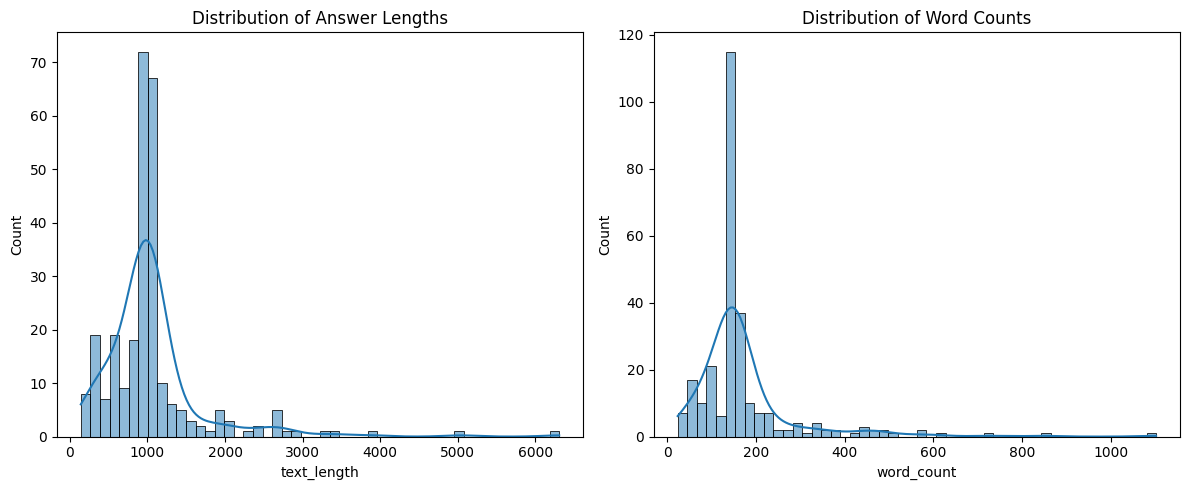

In [70]:
print("\n🔍 Target value distribution:")
print(train_df['is_cheating'].value_counts(normalize=True))

train_df['text_length'] = train_df['answer'].astype(str).apply(len)
train_df['word_count'] = train_df['answer'].astype(str).apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(train_df['text_length'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Answer Lengths")

sns.histplot(train_df['word_count'], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Word Counts")

plt.tight_layout()
plt.show()

In [71]:
train = pd.read_csv("../Mecor_Data/train.csv")
test = pd.read_csv("../Mecor_Data/test.csv")

In [72]:
X = train['answer']
y = train['is_cheating']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train_tfidf, y_train)

y_pred = model.predict_proba(X_val_tfidf)[:, 1]
roc = roc_auc_score(y_val, y_pred)

print(f"✅ ROC-AUC Score: {roc:.4f}")

✅ ROC-AUC Score: 0.9667


In [73]:
vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1,2), stop_words='english')
X_tfidf = vectorizer.fit_transform(train['answer'])
y = train['is_cheating']

models = {
    "lr": LogisticRegression(max_iter=1000, solver='liblinear'),
    "rf": RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42),
    "xgb": XGBClassifier(eval_metric='logloss', n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42),
    "lgb": LGBMClassifier(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
}

for name, model in models.items():
    model.fit(X_tfidf, y)
    preds = model.predict_proba(X_tfidf)[:, 1]
    score = roc_auc_score(y, preds)

ensemble = VotingClassifier(
    estimators=[(k, v) for k, v in models.items()],
    voting='soft'
)
ensemble.fit(X_tfidf, y)
ensemble_preds = ensemble.predict_proba(X_tfidf)[:, 1]
ensemble_score = roc_auc_score(y, ensemble_preds)
print(f"Ensemble ROC-AUC: {ensemble_score:.4f}")

[LightGBM] [Info] Number of positive: 147, number of negative: 122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 961
[LightGBM] [Info] Number of data points in the train set: 269, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546468 -> initscore=0.186412
[LightGBM] [Info] Start training from score 0.186412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\asus\Desktop\Mecor_Text_Dection_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 147, number of negative: 122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 961
[LightGBM] [Info] Number of data points in the train set: 269, number of used features: 85
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546468 -> initscore=0.186412
[LightGBM] [Info] Start training from score 0.186412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

c:\Users\asus\Desktop\Mecor_Text_Dection_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [74]:
X_test_tfidf = vectorizer.transform(test['answer'])
test_preds = ensemble.predict_proba(X_test_tfidf)[:, 1]

submission = pd.DataFrame({
    "answer_id": test["id"],
    "score": test_preds
})

submission.to_csv("ensemble_submission.csv", index=False)
print("✅ Submission saved as ensemble_submission.csv")

✅ Submission saved as ensemble_submission.csv


c:\Users\asus\Desktop\Mecor_Text_Dection_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [75]:
vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1,2), stop_words='english')
X_tfidf = vectorizer.fit_transform(train['answer'])
y = train['is_cheating']

models = {
    "lr": LogisticRegression(max_iter=1000, solver='liblinear'),
    "rf": RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42),
    "xgb": XGBClassifier(eval_metric='logloss', n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42),
    "lgb": LGBMClassifier(n_estimators=300, learning_rate=0.1, max_depth=6, random_state=42)
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros((len(y), len(models)))
test_preds = np.zeros((len(test), len(models)))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_tfidf, y)):
    X_train, X_val = X_tfidf[train_idx], X_tfidf[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    for j, (name, model) in enumerate(models.items()):
        model.fit(X_train, y_train)
        val_pred = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx, j] = val_pred
        test_preds[:, j] += model.predict_proba(vectorizer.transform(test['answer']))[:, 1] / kf.n_splits
        print(f"{name} fold ROC-AUC: {roc_auc_score(y_val, val_pred):.4f}")

meta_features = pd.DataFrame(oof_preds, columns=models.keys())
print("\n✅ Base model training done! Meta features created:", meta_features.shape)

lr fold ROC-AUC: 0.9597
rf fold ROC-AUC: 0.9222
xgb fold ROC-AUC: 0.9056
[LightGBM] [Info] Number of positive: 117, number of negative: 98
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 215, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544186 -> initscore=0.177206
[LightGBM] [Info] Start training from score 0.177206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

c:\Users\asus\Desktop\Mecor_Text_Dection_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


rf fold ROC-AUC: 0.9653
xgb fold ROC-AUC: 0.8500
[LightGBM] [Info] Number of positive: 117, number of negative: 98
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 499
[LightGBM] [Info] Number of data points in the train set: 215, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544186 -> initscore=0.177206
[LightGBM] [Info] Start training from score 0.177206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

c:\Users\asus\Desktop\Mecor_Text_Dection_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


rf fold ROC-AUC: 0.8772
xgb fold ROC-AUC: 0.8510
[LightGBM] [Info] Number of positive: 118, number of negative: 97
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 215, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.548837 -> initscore=0.195974
[LightGBM] [Info] Start training from score 0.195974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

c:\Users\asus\Desktop\Mecor_Text_Dection_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


rf fold ROC-AUC: 0.9421
xgb fold ROC-AUC: 0.7959
[LightGBM] [Info] Number of positive: 118, number of negative: 97
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 521
[LightGBM] [Info] Number of data points in the train set: 215, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.548837 -> initscore=0.195974
[LightGBM] [Info] Start training from score 0.195974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

c:\Users\asus\Desktop\Mecor_Text_Dection_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


lgb fold ROC-AUC: 0.7566
lr fold ROC-AUC: 0.9713
rf fold ROC-AUC: 0.9569
xgb fold ROC-AUC: 0.8218
[LightGBM] [Info] Number of positive: 118, number of negative: 98
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546296 -> initscore=0.185717
[LightGBM] [Info] Start training from score 0.185717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

c:\Users\asus\Desktop\Mecor_Text_Dection_Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [76]:
meta_model = LogisticRegression(max_iter=1000)

meta_model.fit(oof_preds, y)

final_preds = meta_model.predict_proba(test_preds)[:, 1]

submission = pd.DataFrame({
    "answer_id": test_df["id"],
    "score": final_preds
})

submission.to_csv("stacked_submission.csv", index=False)
print("✅ Final stacked model submission saved as stacked_submission.csv")
submission.head()

✅ Final stacked model submission saved as stacked_submission.csv


,answer_id,score
0,scr_81822029c661,0.433588
1,scr_52efb19e0ea9,0.737583
2,scr_8fc0f33c559e,0.340163
3,scr_bac3f5d3aa12,0.222599
4,scr_adfbe009984d,0.431138


In [77]:
meta_X = meta_features
meta_y = y

meta_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
meta_model.fit(meta_X, meta_y)

meta_oof_preds = meta_model.predict_proba(meta_X)[:, 1]
meta_auc = roc_auc_score(meta_y, meta_oof_preds)
print(f"\n✅ Meta-model (stacked) ROC-AUC on OOF data: {meta_auc:.4f}")

test_meta = pd.DataFrame(test_preds, columns=models.keys())
final_preds = meta_model.predict_proba(test_meta)[:, 1]

submission = pd.DataFrame({
    'answer_id': test['id'],
    'score': final_preds
})
submission.to_csv("stacked_submission.csv", index=False)
submission.head()

[LightGBM] [Info] Number of positive: 147, number of negative: 122
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 269, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546468 -> initscore=0.186412
[LightGBM] [Info] Start training from score 0.186412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

,answer_id,score
0,scr_81822029c661,0.657733
1,scr_52efb19e0ea9,0.999027
2,scr_8fc0f33c559e,0.954864
3,scr_bac3f5d3aa12,0.000870
4,scr_adfbe009984d,0.006311


In [78]:
sub = pd.read_csv("stacked_submission.csv")
sub.rename(columns={"answer_id": "id"}, inplace=True)
sub.to_csv("stacked_submission_2.csv", index=False)

In [79]:
sub = pd.read_csv("stacked_submission.csv")
sub.rename(columns={"answer_id": "id"}, inplace=True)
sub.to_csv("stacked_submission_2.csv", index=False)

sub.head()

,id,score
0,scr_81822029c661,0.657733
1,scr_52efb19e0ea9,0.999027
2,scr_8fc0f33c559e,0.954864
3,scr_bac3f5d3aa12,0.000870
4,scr_adfbe009984d,0.006311


In [80]:
sub1 = pd.read_csv("stacked_submission_fixed.csv")
sub2 = pd.read_csv("ensemble_submission.csv")

In [81]:
sub2.rename(columns={"answer_id": "id"}, inplace=True)

blend = sub1.merge(sub2, on="id", suffixes=("_stacked", "_ensemble"))

blend["score"] = 0.6 * blend["score_stacked"] + 0.4 * blend["score_ensemble"]

blend[["id", "score"]].to_csv("super_blend_submission.csv", index=False)
print("✅ Super blend submission saved as super_blend_submission.csv")

blend.head()

✅ Super blend submission saved as super_blend_submission.csv


,id,score_stacked,score_ensemble,score
0,scr_81822029c661,0.657733,0.362513,0.539645
1,scr_52efb19e0ea9,0.999027,0.704398,0.881175
2,scr_8fc0f33c559e,0.954864,0.449693,0.752796
3,scr_bac3f5d3aa12,0.000870,0.367055,0.147344
4,scr_adfbe009984d,0.006311,0.510624,0.208036


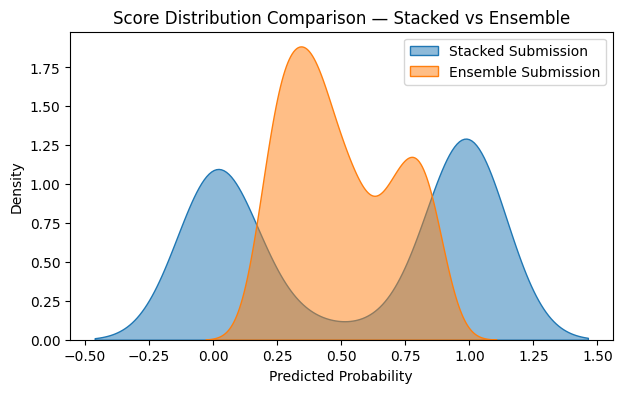

In [82]:
plt.figure(figsize=(7, 4))
sns.kdeplot(blend["score_stacked"], label="Stacked Submission", fill=True, alpha=0.5)
sns.kdeplot(blend["score_ensemble"], label="Ensemble Submission", fill=True, alpha=0.5)
plt.title("Score Distribution Comparison — Stacked vs Ensemble")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.show()

---

## 🏁 Results & Notes

- Best model: **Stacked LGBM meta-learner**
- Public Leaderboard Score: **0.95384**
- Base models: Logistic Regression, Random Forest, XGBoost, LightGBM
- Meta features created via 5-Fold Stratified CV
- Final files:
  - `stacked_submission.csv`
  - `stacked_submission_2.csv`
  - `super_blend_submission.csv`

📅 *Project completed: October 2025*